# Taxi Fare Model

**Problem**  
To solve a **Kaggle Competition**: [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction). 

**Goal**  
To predict the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.

## Steps
1. Get the data
2. Explore the data
3. Data cleaning
4. Evaluation metric
5. Model baseline
6. Build your first model
7. Model evaluation
8. Model iteration
9. Kaggle submission

## 1. Data Collection <a id='part1'></a>

The dataset is downloaded from [Kaggle](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data).

In [157]:
import pandas as pd

The training dataset is relatively big (~5GB). So only a portion is used.  
[Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/) - how to open a portion of CSV file and store it into a DataFrame (ex: just read 1 million rows maximum)


In [158]:
%%time
url = '../raw_data/train.csv'
df = pd.read_csv(url, nrows=1_0000)

CPU times: user 93 ms, sys: 45.6 ms, total: 139 ms
Wall time: 135 ms


Now let's display the first rows to understand the different fields 

In [160]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [102]:
df.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.006437,-0.008956,0.003835,-0.003271,0.016155
pickup_longitude,0.006437,1.000000,-0.851847,0.973673,-0.955877,-0.006741
pickup_latitude,-0.008956,-0.851847,1.000000,-0.830989,0.852588,0.004276
dropoff_longitude,0.003835,0.973673,-0.830989,1.000000,-0.972178,-0.009140
dropoff_latitude,-0.003271,-0.955877,0.852588,-0.972178,1.000000,0.008729
passenger_count,0.016155,-0.006741,0.004276,-0.009140,0.008729,1.000000


## 2. Data Exploration <a id='part2'></a>

To see the overview of the data, we will be plotting out the features available to have a general view of their relationships

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 14
plt.figure(figsize=(12,5))
palette = sns.color_palette('Paired', 10)

<Figure size 864x360 with 0 Axes>

### Data exploration objectives

- Inspect the distribution of the target variable: "fare_amount"
- Visualize distributions of other variables
- Compute and visualize the correlation between the target variable and other variables
- Check for any missing values, or other irregularities

### Explore the target variable
- Compute simple statistics for the target variable (min, max, mean, std, etc)
- Plot distributions

In [104]:
df.fare_amount.describe()

count    10000.000000
mean        11.235464
std          9.584258
min         -2.900000
25%          6.000000
50%          8.500000
75%         12.500000
max        180.000000
Name: fare_amount, dtype: float64

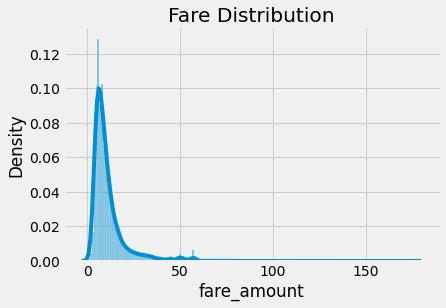

In [105]:
def plot_dist(series=df["fare_amount"], title="Fare Distribution"):
    sns.histplot(series, kde=True, stat='density', discrete=True)
    sns.despine()
    plt.title(title);
    plt.show()
plot_dist()

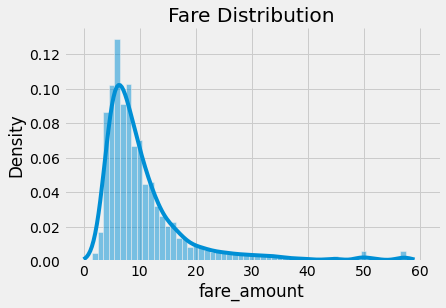

In [106]:
# drop absurd values 
df = df[df.fare_amount.between(0, 60)]
plot_dist(df.fare_amount)

In [107]:
import numpy as np 

# we can also visualize binned fare_amount variable
df['fare-bin'] = pd.cut(df['fare_amount'], bins = list(range(0, 50, 5)), include_lowest=True).astype('str')

# uppermost bin
df['fare-bin'] = df['fare-bin'].replace("nan", '[45+]')
# df.loc[df['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# apply this to clean up the label of the first bin
df['fare-bin'] = df['fare-bin'].apply(lambda x: x.replace('-0.001', '0'))

# sort by fare the correct look in the chart
df = df.sort_values(by='fare_amount')

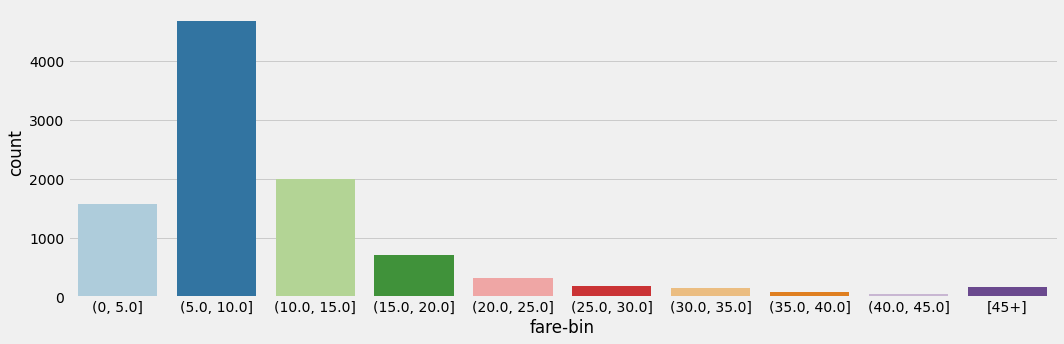

In [108]:
sns.catplot(x="fare-bin", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.show()

### Explore other variables

- passenger_count (statistics + distribution)
- pickup_datetime
- Geospatial features (pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude)
- Find other variables that can compute from existing data and that might explain the target

#### Passenger Count

In [109]:
df.passenger_count.describe()

count    9979.000000
mean        1.645355
std         1.272066
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

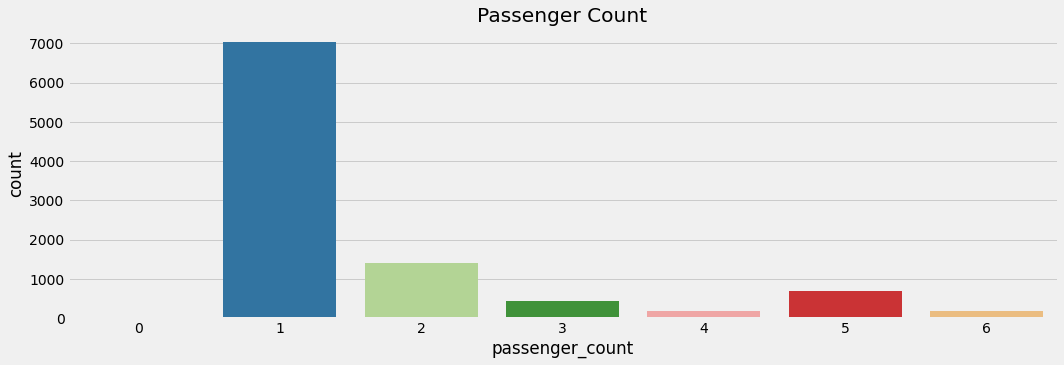

In [110]:
sns.catplot(x="passenger_count", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Passenger Count');
plt.show()

#### Pickup Datetime

- Extract time features from pickup_datetime (hour, day of week, month, year)
- Create a method `def extract_time_features(_df)` that you will be able to re-use later

In [1]:
#timezone is converted as per new york time zone
def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

In [112]:
%%time
df = extract_time_features(df)

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.01 s


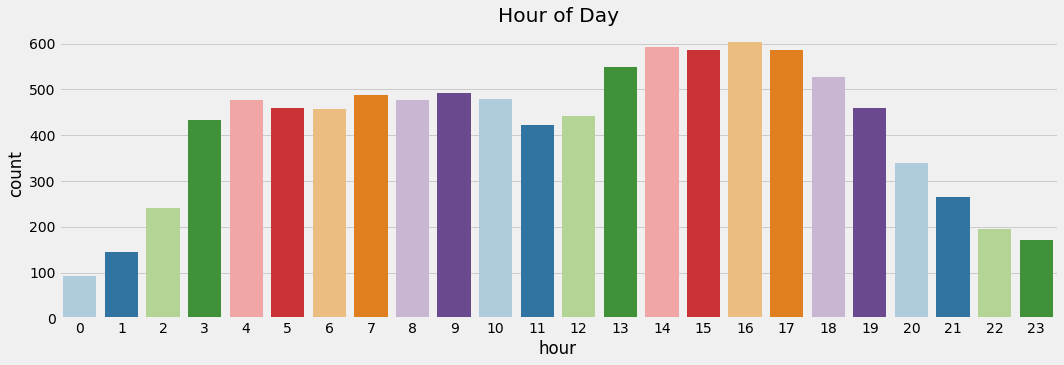

In [113]:
# hour of day
sns.catplot(x="hour", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

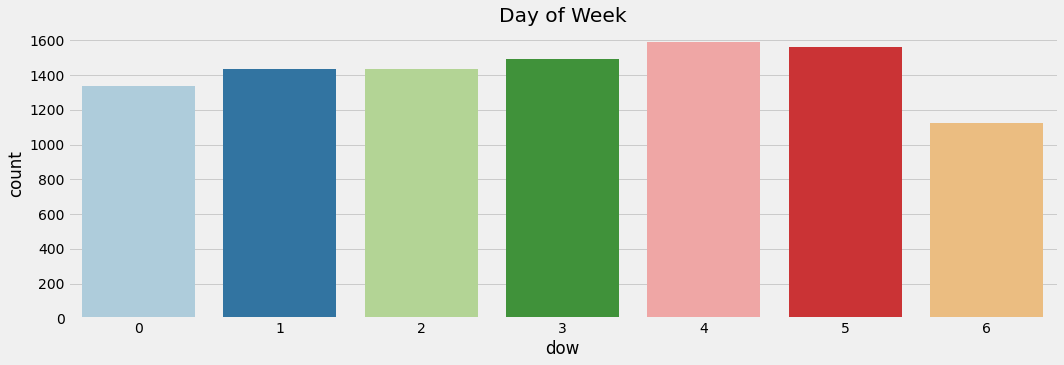

In [114]:
# day of week
sns.catplot(x="dow", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

#### Pickup and Dropoff locations

- Look at the outliers
- Only keep the observations where the rides occur around New York City
- Create a timed heatmap for the rides using Folium

In [115]:
df_test = pd.read_csv("../raw_data/test.csv")

In [116]:
# find the boudaries from the test set and remove the outliers from the training set
for col in ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]:
    MIN = df_test[col].min()
    MAX = df_test[col].max()
    print(col, MIN, MAX)

pickup_latitude 40.573143 41.709555
pickup_longitude -74.252193 -72.986532
dropoff_latitude 40.568973 41.696683
dropoff_longitude -74.263242 -72.990963


In [117]:
df = df[df["pickup_latitude"].between(left = 40, right = 42 )]
df = df[df["pickup_longitude"].between(left = -74.3, right = -72.9 )]
df = df[df["dropoff_latitude"].between(left = 40, right = 42 )]
df = df[df["dropoff_longitude"].between(left = -74, right = -72.9 )]

In [118]:
# make sure that you install folium first
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [119]:
center_location = [40.758896, -73.985130]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11)

In [120]:
df["count"] =1
heatmap_data = df.head(10000)[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

#### Distance

- Compute the distance between pickup and dropoff locations (tip: https://en.wikipedia.org/wiki/Haversine_formula)
- Compute a few statistics for distance and plot distance distribution
- Create a method `def haversine_distance(df, **kwargs)` to be reused later

In [121]:
import numpy as np
def haversine_distance(df,
                       start_lat="start_lat",
                       start_lon="start_lon",
                       end_lat="end_lat",
                       end_lon="end_lon"):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Vectorized version of the haversine distance for pandas df
    Computes distance in kms
    """

    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6371 * c
    return haversine_distance

df["distance"] = haversine_distance(df, 
                                    start_lat="pickup_latitude", start_lon="pickup_longitude",
                                    end_lat="dropoff_latitude", end_lon="dropoff_longitude")

In [122]:
df.distance.describe()

count    8529.000000
mean        3.361152
std         4.359258
min         0.000000
25%         1.231623
50%         2.125326
75%         3.855249
max        99.771579
Name: distance, dtype: float64

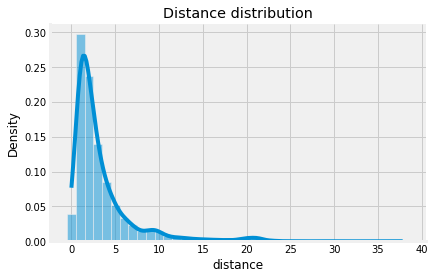

In [123]:
%matplotlib inline
plot_dist(series=df[df.distance < 50].distance, title='Distance distribution')

#### Explore how target variable correlate with other variables

- Visualization of the target variable vs another variable

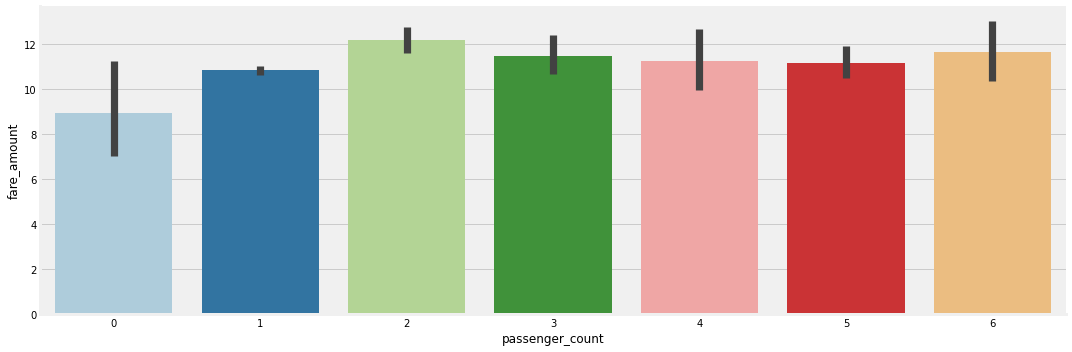

In [124]:
sns.catplot(x="passenger_count", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

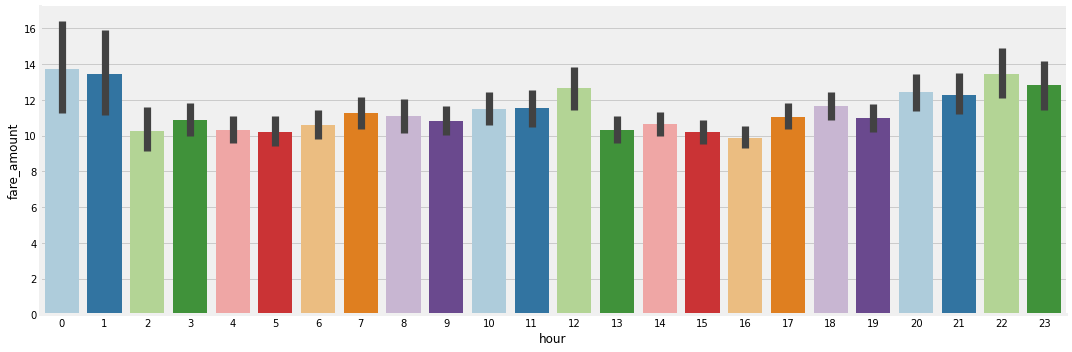

In [125]:
sns.catplot(x="hour", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

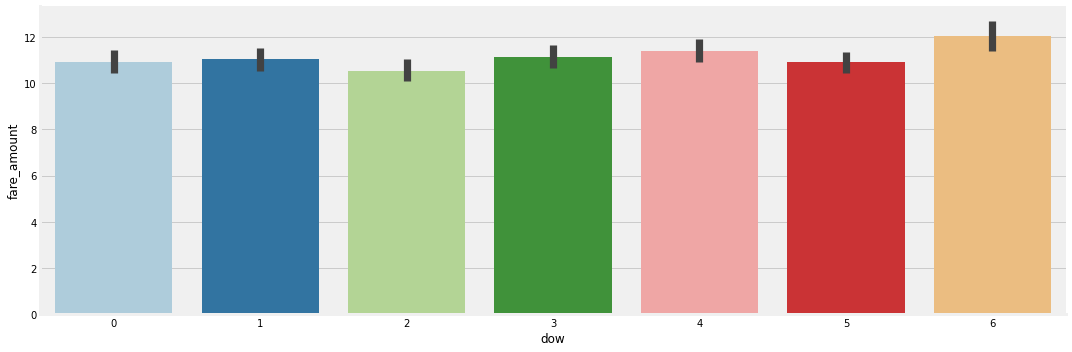

In [126]:
sns.catplot(x="dow", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

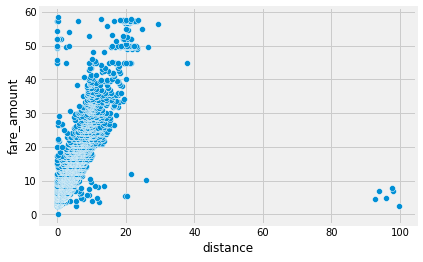

In [127]:
sns.scatterplot(x="distance", y="fare_amount", data=df)
plt.show()

In [128]:
df_update = df[df['distance']<80]
df_update = df_update[df_update['distance']>0]
df_update.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year,count,distance
0,2015-05-01 15:38:41.0000007,0.01,2015-05-01 15:38:41 UTC,-73.939041,40.713963,-73.941673,40.713997,1,"(0, 5.0]",4,11,5,2015,1,0.221878
1,2010-10-16 13:21:30.0000002,2.50,2010-10-16 13:21:30 UTC,-73.983347,40.771135,-73.984194,40.771359,1,"(0, 5.0]",5,9,10,2010,1,0.075550
6,2009-02-03 15:49:00.00000012,2.50,2009-02-03 15:49:00 UTC,-73.991475,40.754698,-73.991620,40.754885,1,"(0, 5.0]",1,10,2,2009,1,0.024115
7,2010-04-25 06:13:04.0000001,2.50,2010-04-25 06:13:04 UTC,-73.973214,40.790254,-73.972983,40.790556,1,"(0, 5.0]",6,2,4,2010,1,0.038805
8,2014-10-07 05:01:33.0000001,2.50,2014-10-07 05:01:33 UTC,-73.725993,40.686509,-73.726348,40.685597,1,"(0, 5.0]",1,1,10,2014,1,0.105735


All distance around 100km points to a location (41.366138, -73.137393). It is in Seymour, CT, USA. It'll not be included as we're predicting the taxi fare within NYC.

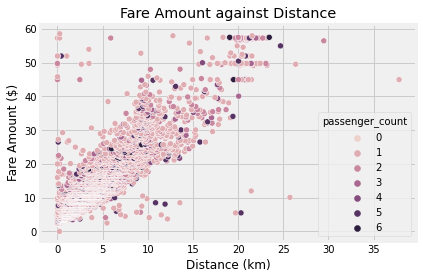

In [129]:
sns.scatterplot(x="distance", y="fare_amount", hue="passenger_count", data=df_update)
plt.title("Fare Amount against Distance")
plt.ylabel("Fare Amount ($)")
plt.xlabel("Distance (km)")
plt.show()

## 3. Data cleaning <a id='part3'></a>

As you probably saw in the previous section during your data exploration, there are some values that do not seem valid.
Some data will be cleaned and not included in the training data.

Remove all the trips that look incorrect with a `clean_data(df)` method

In [130]:
print("trips with negative fares:", len(df[df.fare_amount <= 0]))
print("trips with too high distance:", len(df[df.distance >= 90]))
print("trips with too many passengers:", len(df[df.passenger_count > 8]))
print("trips with zero passenger:", len(df[df.passenger_count == 0]))

trips with negative fares: 0
trips with too high distance: 6
trips with too many passengers: 0
trips with zero passenger: 31


In [131]:
def clean_data(df, test=False):
    df = df.dropna(how='any', axis='rows')
    df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0)]
    df = df[(df.pickup_latitude != 0) | (df.pickup_longitude != 0)]
    df = df[df.fare_amount.between(0, 4000)]
    df = df[df.passenger_count < 8]
    df = df[df.passenger_count > 0]
    df = df[df["pickup_latitude"].between(40, 42)]
    df = df[df["pickup_longitude"].between(-74.3, -72.9 )]
    df = df[df["dropoff_latitude"].between(40, 42)]
    df = df[df["dropoff_longitude"].between(-74, -72.9)]
    df = df[df["distance"]<80]
    df = df[df["distance"]>0]
    
    return df

df_cleaned = clean_data(df)
"% data removed", (1 - len(df_cleaned) / len(df)) * 100

('% data removed', 1.4186891780982536)

In [132]:
df_cleaned = df_cleaned.drop(columns=['count','fare-bin'])

In [133]:
df_cleaned.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year,distance
0,2015-05-01 15:38:41.0000007,0.01,2015-05-01 15:38:41 UTC,-73.939041,40.713963,-73.941673,40.713997,1,4,11,5,2015,0.221878
1,2010-10-16 13:21:30.0000002,2.50,2010-10-16 13:21:30 UTC,-73.983347,40.771135,-73.984194,40.771359,1,5,9,10,2010,0.075550
6,2009-02-03 15:49:00.00000012,2.50,2009-02-03 15:49:00 UTC,-73.991475,40.754698,-73.991620,40.754885,1,1,10,2,2009,0.024115
7,2010-04-25 06:13:04.0000001,2.50,2010-04-25 06:13:04 UTC,-73.973214,40.790254,-73.972983,40.790556,1,6,2,4,2010,0.038805
8,2014-10-07 05:01:33.0000001,2.50,2014-10-07 05:01:33 UTC,-73.725993,40.686509,-73.726348,40.685597,1,1,1,10,2014,0.105735


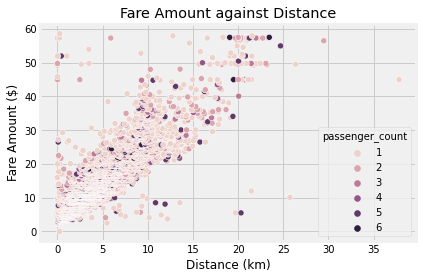

In [134]:
sns.scatterplot(x="distance", y="fare_amount", hue="passenger_count", data=df_cleaned)
plt.title("Fare Amount against Distance")
plt.ylabel("Fare Amount ($)")
plt.xlabel("Distance (km)")
plt.show()

In [135]:
df_corr = df_cleaned.corr()
df_corr = df_corr[['fare_amount']]

In [136]:
df_corr = df_corr.drop(index='fare_amount')
df_corr

,fare_amount
pickup_longitude,0.418173
pickup_latitude,-0.264701
dropoff_longitude,0.484483
dropoff_latitude,-0.139096
passenger_count,0.022892
dow,0.027055
hour,0.024537
month,0.046231
year,0.113897
distance,0.892570


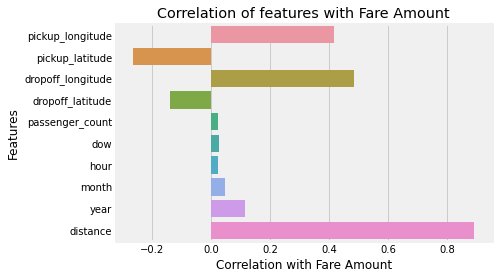

In [138]:
sns.barplot(data=df_corr, y= df_corr.index,  x = df_corr.columns[0])
plt.xlabel("Correlation with Fare Amount")
plt.ylabel("Features")
plt.title("Correlation of features with Fare Amount")
plt.show()

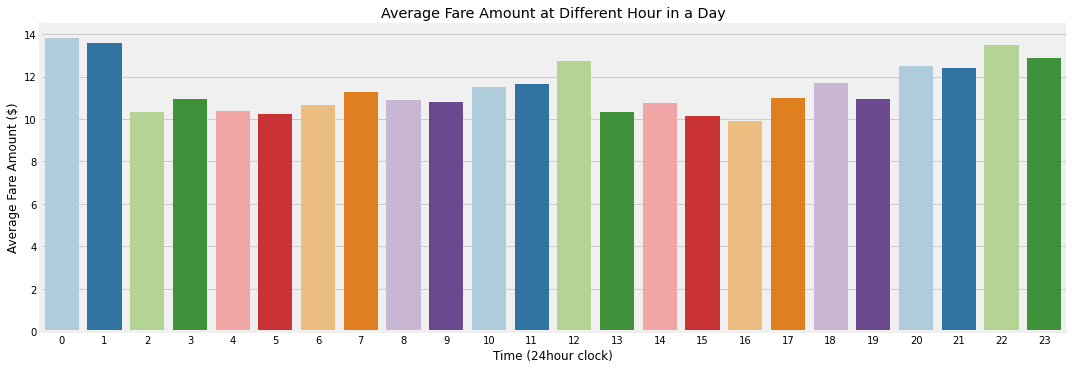

In [139]:
sns.catplot(x="hour", y="fare_amount", palette=palette, data=df_cleaned, kind="bar", aspect=3, ci=None)
sns.despine()
plt.ylabel("Average Fare Amount ($)")
plt.xlabel("Time (24hour clock)")
plt.title("Average Fare Amount at Different Hour in a Day")
plt.show()

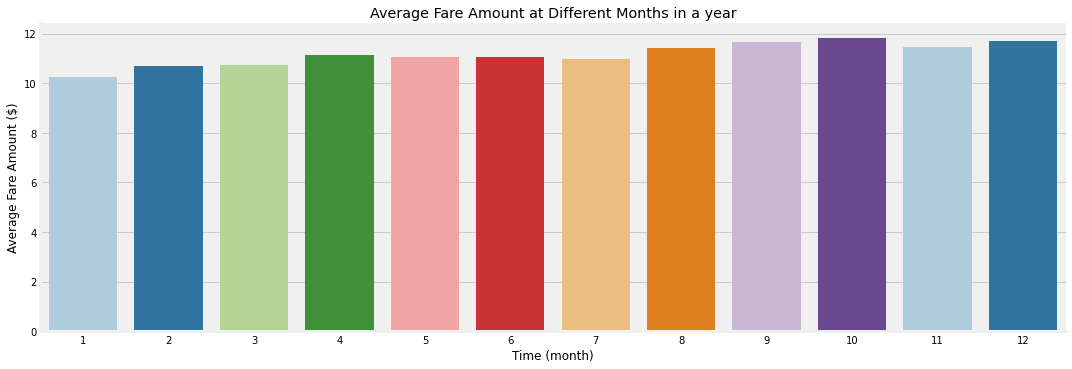

In [140]:
sns.catplot(x="month", y="fare_amount", palette=palette, data=df_cleaned, kind="bar", aspect=3, ci=None)
sns.despine()
plt.ylabel("Average Fare Amount ($)")
plt.xlabel("Time (month)")
plt.title("Average Fare Amount at Different Months in a year")
plt.show()

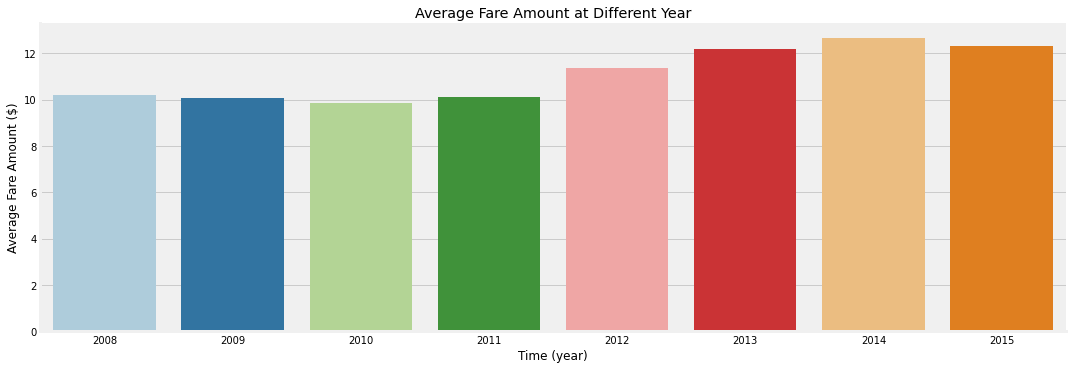

In [141]:
sns.catplot(x="year", y="fare_amount", palette=palette, data=df_cleaned, kind="bar", aspect=3, ci=None)
sns.despine()
plt.ylabel("Average Fare Amount ($)")
plt.xlabel("Time (year)")
plt.title("Average Fare Amount at Different Year")
plt.show()

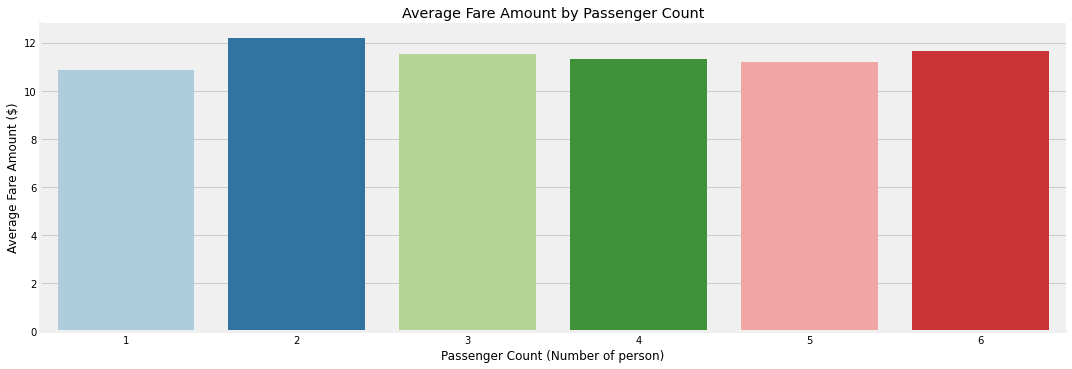

In [142]:
sns.catplot(x="passenger_count", y="fare_amount", palette=palette, data=df_cleaned, kind="bar", aspect=3, ci=None)
sns.despine()
plt.xlabel("Passenger Count (Number of person)")
plt.ylabel("Average Fare Amount ($)")
plt.title("Average Fare Amount by Passenger Count")
plt.show()

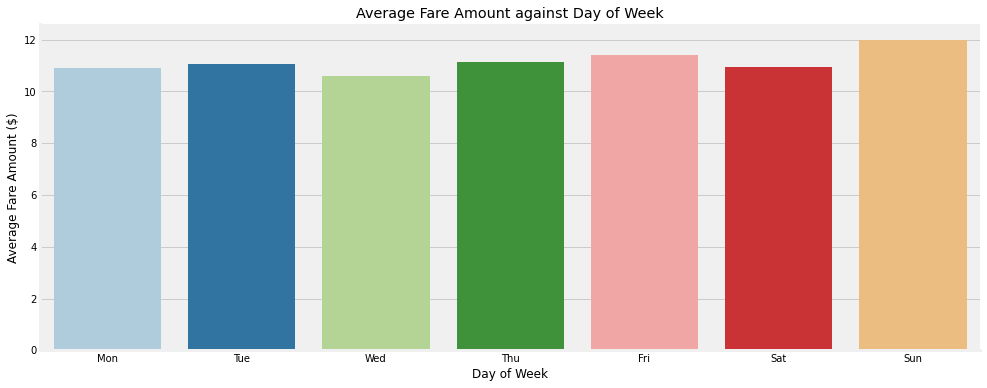

In [143]:
fig, axes = plt.subplots(1,1, figsize=(15,6))
sns.barplot(x="dow", y="fare_amount", palette=palette, data=df_cleaned, ci=None, ax=axes)
sns.despine()
plt.xlabel("Day of Week")
plt.ylabel("Average Fare Amount ($)")
plt.title("Average Fare Amount against Day of Week")
axes.set_xticklabels(["Mon","Tue","Wed",'Thu',"Fri","Sat","Sun"])
plt.show()

In [144]:
df_cleaned.groupby(by='hour').mean()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,month,year,distance
hour,,,,,,,,,,
0,13.811928,-73.973839,40.745258,-73.950747,40.743096,1.698795,4.036145,6.000000,2011.855422,4.878976
1,13.582982,-73.967160,40.750598,-73.956331,40.754974,1.517544,2.666667,6.517544,2011.833333,4.596939
2,10.311650,-73.973561,40.756794,-73.968879,40.756281,1.533981,2.427184,6.135922,2011.830097,3.148919
3,10.923961,-73.972637,40.754988,-73.969185,40.758634,1.412742,2.578947,6.174515,2011.927978,3.314745
4,10.376813,-73.973878,40.756790,-73.972309,40.757953,1.562044,2.615572,6.299270,2011.875912,2.772368
5,10.227751,-73.973806,40.755805,-73.972894,40.758373,1.706349,2.656085,5.978836,2011.743386,2.725748
6,10.662760,-73.973427,40.756684,-73.972789,40.758316,1.682292,3.059896,5.856771,2011.611979,2.978481
7,11.264289,-73.974947,40.754537,-73.969026,40.755069,1.503741,2.995012,5.865337,2011.763092,3.244113
8,10.917698,-73.973167,40.755661,-73.970241,40.756496,1.726343,2.918159,6.501279,2011.757033,2.806713
